In [216]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

# Correlation
from scipy.stats import chi2_contingency
import seaborn as sns

# PCA
from sklearn.decomposition import PCA

# KMeans
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score,calinski_harabasz_score 

# KNN
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

# Random Forest
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# fuzzy matching
from thefuzz import process

import os

In [217]:
filepath = "preprocessed_data/Ligue_1_outfield_unique.csv"
outfield_df = pd.read_csv(filepath)

# Extract just the filename (e.g., 'Serie_A_Scouting_Data_outfield_stats.csv')
filename = os.path.basename(filepath)

# Remove the suffix to get 'Serie_A_Scouting_Data'
league_name = filename.replace('_outfield_unique.csv', '')

In [218]:
FEATURE_IMPORTANT_THRESHOLD = 0.005

Feature Engineering

In [219]:
# Compute the Goals per Expected Goals Ratio
outfield_df["Finishing_Efficiency"] = outfield_df["Per90_Goals"] / outfield_df["Per90_Goals - xG"]

# Handle cases where xG is zero (avoid division by zero)
outfield_df["Finishing_Efficiency"].fillna(0, inplace=True)
outfield_df["Finishing_Efficiency"] = outfield_df["Finishing_Efficiency"].replace(np.inf, 0)

# Drop Per90_Goals - xG
outfield_df = outfield_df.drop(columns=["Per90_Goals - xG"])

# Compute the Assists per Expected Assists Ratio
outfield_df["Assist_Efficiency"] = outfield_df["Per90_Assists"] / outfield_df["Per90_xA: Expected Assists"]
outfield_df["Assist_Efficiency"].fillna(0, inplace=True)
outfield_df["Assist_Efficiency"] = outfield_df["Assist_Efficiency"].replace(np.inf, 0)
outfield_df = outfield_df.drop(columns=["Per90_xA: Expected Assists"])

# Compute Shot Efficiency (Goals per Shot)
outfield_df["Shot_Efficiency"] = outfield_df["Per90_Goals"] / outfield_df["Per90_Shots Total"]
outfield_df["Shot_Efficiency"].fillna(0, inplace=True)
outfield_df["Shot_Efficiency"] = outfield_df["Shot_Efficiency"].replace(np.inf, 0)
outfield_df.drop(columns=["Per90_Shots Total"], inplace=True)

# Compute Passing Efficiency (Pass Completion Ratio)
outfield_df["Pass_Efficiency"] = outfield_df["Per90_Passes Completed"] / outfield_df["Per90_Passes Attempted"]
outfield_df["Pass_Efficiency"].fillna(0, inplace=True)
outfield_df["Pass_Efficiency"] = outfield_df["Pass_Efficiency"].replace(np.inf, 0)
outfield_df.drop(columns=["Per90_Passes Attempted", "Per90_Passes Completed"], inplace=True)

# Compute Possession Lost Ratio (Dispossessed + Miscontrols per Touch)
outfield_df["Possession_Lost_Ratio"] = (outfield_df["Per90_Dispossessed"] + outfield_df["Per90_Miscontrols"]) / outfield_df["Per90_Touches"]
outfield_df["Possession_Lost_Ratio"].fillna(0, inplace=True)
outfield_df["Possession_Lost_Ratio"] = outfield_df["Possession_Lost_Ratio"].replace(np.inf, 0)

# Compute Progressive Play Contribution (Progressive Carries + Progressive Passes)
outfield_df["Progressive_Play"] = outfield_df["Per90_Progressive Carries"] + outfield_df["Per90_Progressive Passes"]

# Compute Ball Retention Ability (Successful Take-Ons / Take-On Attempts)
outfield_df["Ball_Retention"] = outfield_df["Per90_Successful Take-Ons"] / outfield_df["Per90_Take-Ons Attempted"]
outfield_df["Ball_Retention"].fillna(0, inplace=True)
outfield_df["Ball_Retention"] = outfield_df["Ball_Retention"].replace(np.inf, 0)
outfield_df.drop(columns=["Per90_Take-Ons Attempted", "Per90_Successful Take-Ons"], inplace=True)

# Compute Set-Piece Involvement (Total Contribution from Set-Pieces)
outfield_df["Set_Piece_Involvement"] = (
    outfield_df["Per90_Corner Kicks"] +
    outfield_df["Per90_Passes from Free Kicks"] +
    outfield_df["Per90_Penalty Kicks Attempted"]
)
outfield_df.drop(columns=["Per90_Corner Kicks", "Per90_Passes from Free Kicks", "Per90_Penalty Kicks Attempted"], inplace=True)


Investigate feature importance

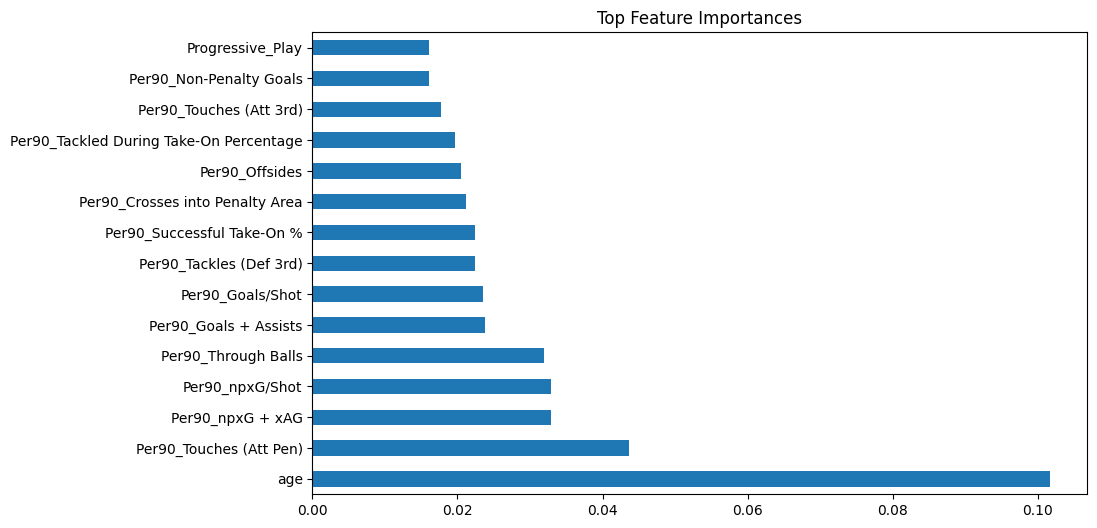

In [220]:
from sklearn.ensemble import RandomForestRegressor

# Define features and target
X = outfield_df.drop(columns=["player_market_value_euro", "Player"])  # Features
y = outfield_df["player_market_value_euro"]  # Target

# Train a simple model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# Plot feature importance
feature_importance = pd.Series(model.feature_importances_, index=X.columns)
feature_importance.nlargest(15).plot(kind='barh', figsize=(10, 6), title="Top Feature Importances")
plt.show()

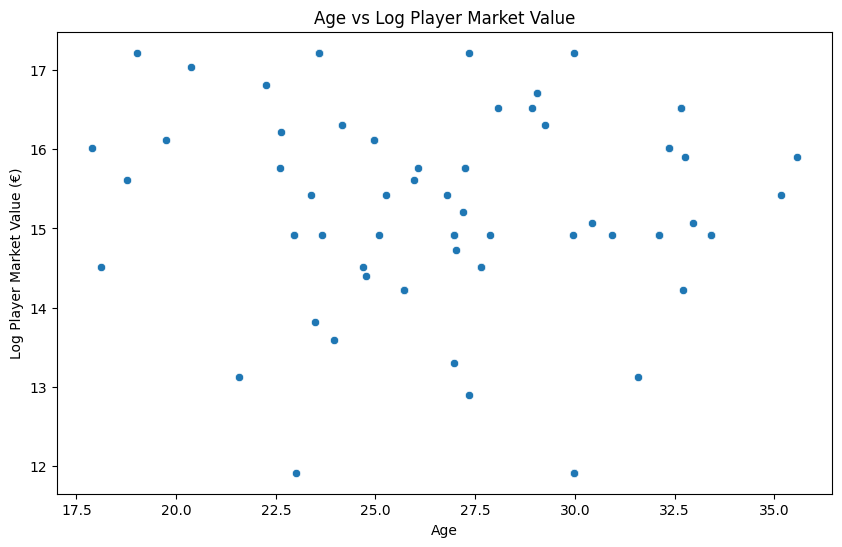

Text(0.5, 1.0, 'Age vs Player Market Value')

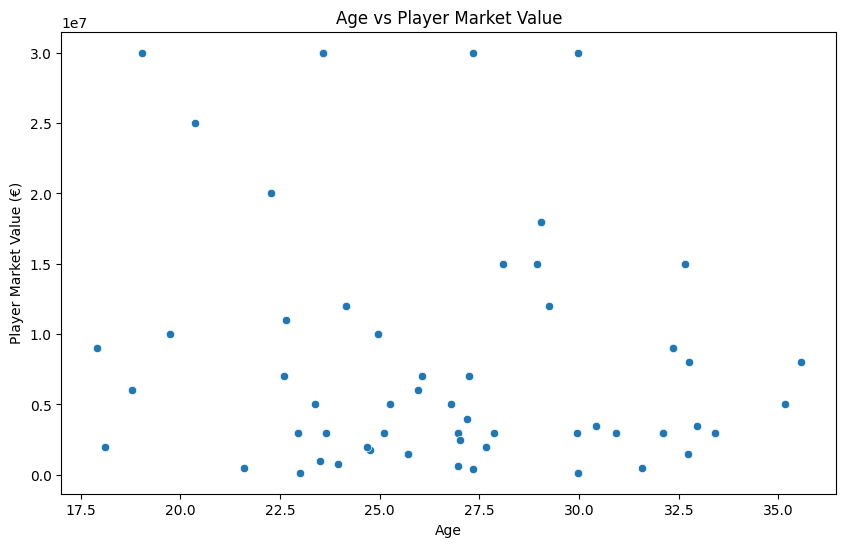

In [221]:
# Visualise age against player_market_value_euro
plt.figure(figsize=(10, 6))
sns.scatterplot(x=outfield_df['age'], y=outfield_df['player_market_value_euro'])
plt.xlabel('Age')
plt.ylabel('Log Player Market Value (€)')
plt.title('Age vs Log Player Market Value')
plt.show()

# Visualise as un-logged valuation
plt.figure(figsize=(10, 6))
sns.scatterplot(x=outfield_df['age'], y=np.exp(outfield_df['player_market_value_euro']))
plt.xlabel('Age')
plt.ylabel('Player Market Value (€)')
plt.title('Age vs Player Market Value')

Drop features with low importance and based on domain knowledge

In [222]:
# Identify features to drop (importance < 0.01)
drop_features = feature_importance[feature_importance < FEATURE_IMPORTANT_THRESHOLD].index

# Debugging Step: Print features to be dropped
print(f"Dropping {len(drop_features)} features due to low importance.\n")

# Ensure only numerical columns are dropped in the main dataset
common_columns_to_drop = [col for col in drop_features if col in outfield_df.columns]

# Drop features from both X and outfield_df
X = X.drop(columns=drop_features)
outfield_df = outfield_df.drop(columns=common_columns_to_drop)

print(f"Number of features after dropping non-important features: {X.shape[1]}")

Dropping 60 features due to low importance.

Number of features after dropping non-important features: 56


Standardise numerical features

In [223]:
scaler = StandardScaler()
statistical_cols = [col for col in outfield_df.columns if col not in ['Player', 'player_market_value_euro']]
outfield_df[statistical_cols] = scaler.fit_transform(outfield_df[statistical_cols])

Finding correlation between features 

In [224]:
# Function to compute Cramér's V
def cramers_v(cat_variable, num_variable):
    contingency_table = pd.crosstab(outfield_df[cat_variable], pd.qcut(outfield_df[num_variable], q=4))
    chi2 = chi2_contingency(contingency_table)[0]
    n = outfield_df.shape[0]
    return np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))

# Identify categorical and numerical columns
categorical_cols = []
non_numeric_cols = ["Player", "player_market_value_euro"] + categorical_cols
numerical_cols = outfield_df.select_dtypes(include=["float64", "int64"]).columns

# Drop non-numeric variables before computing numerical correlations
numerical_df = outfield_df.drop(columns=non_numeric_cols, errors="ignore")

# Compute Pearson correlation for numerical variables
numerical_corr_matrix = numerical_df.corr()

# Initialize Cramér’s V matrix for categorical-numerical correlations
cramers_matrix = pd.DataFrame(index=categorical_cols, columns=numerical_cols)

# Compute Cramér's V for categorical-numerical relationships
for cat_col in categorical_cols:
    for num_col in numerical_cols:
        if cat_col != num_col:
            cramers_matrix.loc[cat_col, num_col] = cramers_v(cat_col, num_col)

# Convert Cramér’s V values to float
cramers_matrix = cramers_matrix.astype(float)

# Merge Pearson correlation with Cramér’s V correlation
full_correlation_matrix = numerical_corr_matrix.copy()

for cat_col in categorical_cols:
    for num_col in numerical_cols:
        full_correlation_matrix.loc[cat_col, num_col] = cramers_matrix.loc[cat_col, num_col]

# Convert final matrix to float for heatmap
full_correlation_matrix = full_correlation_matrix.astype(float)


In [225]:
# # Set correlation threshold 
# correlation_threshold = 0.9

# # Compute the absolute correlation matrix
# corr_matrix = full_correlation_matrix.abs()

# # Create a set to hold the features to remove
# features_to_remove = set()

# # Iterate through correlation matrix and identify features to drop
# for i in range(len(corr_matrix.columns)):
#     for j in range(i):
#         if corr_matrix.iloc[i, j] > correlation_threshold:  # If correlation is above threshold
#             colname = corr_matrix.columns[i]  # Get feature name
#             features_to_remove.add(colname)  # Add it to the removal list

# # Drop the identified features
# outfield_df_reduced = outfield_df.drop(columns=features_to_remove, errors="ignore")

# # Save the cleaned dataset
# outfield_df_reduced.to_csv("transformed_data/outfield_stats_cleaned.csv", index=False)

# print(f"Removed {len(features_to_remove)} highly correlated features.")
# print(f"Remaining features: {outfield_df_reduced.shape[1]}")
# print(f"Reminding columns: {outfield_df_reduced.columns}")

Dropping highly-correlated data

In [226]:
# top_3_features = ['Player','age', 'Per90_Pass Completion % (Short)', 'Per90_Pass Completion % (Long)', 'Per90_GCA (Live-ball Pass)', 'Per90_Carries', 'Per90_Pass Completion %', 'Finishing_Efficiency']
# outfield_df = outfield_df_reduced[top_3_features]

Reducing Dimension

In [227]:
# # Specify categorical columns to keep
# non_statistical_data = ["Player", "player_market_value_euro"]  

# # Separate categorical and numerical features
# kept_features_df = outfield_df[non_statistical_data].reset_index(drop=True)  # Reset index for safe merge
# features = outfield_df.drop(columns=non_statistical_data)  # Drop categorical columns for PCA

# # Print the number of features before PCA
# print("Number of features before PCA:", features.shape[1])

# # Apply PCA to retain 95% variance
# pca = PCA(n_components=0.95)
# X_pca = pca.fit_transform(features)

# # Convert PCA output back to DataFrame
# pca_df = pd.DataFrame(X_pca, index=outfield_df.index)

# # # Name PCA columns properly
# # pca_df.columns = [f'PCA_{i+1}' for i in range(pca_df.shape[1])]

# # Concatenate categorical columns with PCA-transformed numerical data
# outfield_df = pd.concat([kept_features_df, pca_df.reset_index(drop=True)], axis=1)

# # Print the number of features after PCA
# print("Number of features after PCA:", pca_df.shape[1])

# # Plot PCA explained variance
# plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum(), marker='o')
# plt.xlabel('Number of Components')
# plt.ylabel('Cumulative Explained Variance')
# plt.title("PCA Explained Variance")
# plt.show()

Encoding Categorical Variables (all categorical were dropped as we are manually separating by position)

In [228]:
# print("Columns before encoding:", outfield_df.columns)
# outfield_df = pd.get_dummies(outfield_df, columns=['Versus', 'scouting_period'])
# print("Columns after encoding:", outfield_df.columns)

Others (Removing outliers)

In [229]:
# Save the processed file
output_file = os.path.join("preprocessed_data", f"{league_name}_outfield_processed.csv")
outfield_df.to_csv(output_file, index=False)
print("Merging completed successfully!")
print(f"Number of rows = ", len(outfield_df))

Merging completed successfully!
Number of rows =  92


In [230]:
outfield_df.head()

,Player,Per90_% of Dribblers Tackled,Per90_Aerials Lost,Per90_Aerials Won,Per90_Average Shot Distance,Per90_Ball Recoveries,Per90_Carries into Penalty Area,Per90_Clearances,Per90_Crosses into Penalty Area,Per90_Dribblers Tackled,...,Per90_npxG/Shot,Per90_xAG: Exp. Assisted Goals,Per90_xG: Expected Goals,age,player_market_value_euro,Shot_Efficiency,Possession_Lost_Ratio,Progressive_Play,Ball_Retention,Set_Piece_Involvement
0,Abdoulaye Touré,0.931198,-0.639319,-0.598616,-0.464166,-0.466543,-0.616647,0.611526,0.397032,0.228869,...,-1.666100,-0.617675,-0.990721,1.270919,14.914123,-1.479370,-0.795553,-0.749340,0.067399,-0.608892
1,Abdoulaye Touré,-0.465641,-0.033992,0.260373,2.061401,1.396501,-0.752706,-0.520680,-0.590149,0.112968,...,-1.155998,-0.706497,-0.025224,1.270919,14.914123,-0.224366,-0.108886,0.270466,1.485678,-0.828884
2,Abner,0.720207,-0.359705,-0.510491,0.522430,-0.066597,-0.224750,0.272840,0.846778,0.778478,...,-0.220643,0.079127,-0.629546,-2.160792,16.012735,0.122957,-0.506351,0.196218,-0.088954,0.038478
3,Ado Onaiwu,-1.043594,1.987488,1.720941,-0.537115,-0.929326,0.121027,-0.765739,0.422553,-1.216487,...,1.339993,-0.233661,1.617960,-0.502804,14.403297,0.248944,1.391434,-0.782248,-1.309260,-1.211790
4,Aleksandr Golovin,0.057381,-0.408070,0.123397,-0.024910,0.680724,-0.175285,-0.504539,-0.243910,-0.100239,...,0.327060,-0.025232,-0.013257,-0.789827,17.216708,0.493514,-0.308492,1.130426,0.993454,-0.614347
